In [1]:
import requests
import pandas as pd
import tweepy
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt


In [2]:
#pip install tweepy

In [3]:
ticker = "AAPL"

In [4]:

url = 'https://www.alphavantage.co/query?function=NEWS_SENTIMENT&tickers={}&sort=LATEST&limit=1000&apikey=4FACKAH9964BVDDK'.format(ticker)
r = requests.get(url)
data = r.json()

#print(data)
#print(url)

In [5]:
print(data["feed"][0]['summary'])

The world's best-performing tech stocks have bled an average $125 billion market cap per day for the past 20 days while crypto market cap has risen 11%.


In [6]:

summaries_list = []

for item in range(len(data["feed"])):
    summaries_list.append(data["feed"][item]['summary'])


summaries_df = pd.DataFrame(summaries_list, columns=['Summary'])




In [7]:
summaries_df

,Summary
0,The world's best-performing tech stocks have b...
1,Leading cryptocurrencies edged lower Tuesday a...
2,Advanced Micro Devices Inc. AMD witnessed a si...
3,Deepwater Asset Management's Managing Partner ...
4,"Now down 24% from its high, is it time to poun..."
...,...
678,Apple faces scrutiny from the European Union f...
679,Logitech (LOGI) expands its music-related devi...
680,Sirius XM (SIRI) expands its content with The ...
681,Amazon.com Inc AMZN stock just hit a dazzling ...


In [8]:
summaries_df.iloc[0]

Summary    The world's best-performing tech stocks have b...
Name: 0, dtype: object

In [9]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rajup\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rajup\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\rajup\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [10]:
stop_words = set(stopwords.words('english'))


In [11]:
#cleaning up text

def pre_process(text):
    
    text=text.lower()

    text = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', text,  flags=re.MULTILINE)
    
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)
    
    text=re.sub("(\\d|\\W)+"," ",text)

    text = text.split()
    
    text = [word for word in text if word not in stop_words]

    text = [word for word in text if len(word) >= 3]

    lmtzr = WordNetLemmatizer()

    text = [lmtzr.lemmatize(word) for word in text]
    
    return ' '.join(text)

In [12]:
summaries_df['Summary'] = summaries_df['Summary'].apply(pre_process)

In [13]:
summaries_df.iloc[0]

Summary    world best performing tech stock bled average ...
Name: 0, dtype: object

In [14]:
# API_key = 'qqufydlOQGZZhNukvPYswgVIm'
# API_secret = 'rB0jbJIQSap17yFSjfA0ETLb8gAlILRruK4uzlANfMxI8uqLKN'
# access_token = '1765544832573784064-VEyKLhMpvO9qF7bKsV8PcvOMcelgmk'
# access_token_secret = 'bZ389swg9L1uhP0qnd55LpMQNZz9Ew1emMWrEypQL5Z2R'

# auth = tweepy.OAuth1UserHandler(API_key, API_secret, access_token, access_token_secret)
# api = tweepy.API(auth, wait_on_rate_limit=True)


# search_query = "'AAPL'-filter:retweets AND -filter:replies AND -filter:links"
# print(search_query)
# tweets = tweepy.Cursor(api.search_tweets, q=search_query).items(10)

# # for tweet in tweets:
# #     print(tweet.text)
# #     print('------')



# tweets = api.search_tweets(q = search_query, lang = 'en', count = 10, tweet_mode = 'extended')

# attributes = [[tweet.user.name, tweet.created_at, tweet.favourite_count, tweet.source, tweet.full_text] for tweet in tweets]

# cols = ["User", "Date created", "Number of likes", "Source of tweet", "Tweet"]

# df = pd.DataFrame(attributes, columns = cols)

# # except:
# #     print("error")

# for tweet in tweets:
#     print(tweet.full_text)

In [15]:
# url = "https://newsapi.org/v2/top-headlines"

# params = {
#     "q": "apple",
#     "apiKey": "b5df7b6c5f6a47a78f11b4716a5bfb06"
# }

# response = requests.get(url, params=params)

# print(response.json())

In [16]:
from datasets import load_dataset

dataset = load_dataset("zeroshot/twitter-financial-news-sentiment")

In [17]:
print(len(dataset))


2


In [18]:
#getting training data from zeroshot/twitter-financial-news-sentiment

source1_data = []
for i in range(len(dataset['train'])):
    source1_data.append({'text': dataset['train'][i]['text'], 'label': dataset['train'][i]['label']})
    

for i in range(len(dataset['validation'])):

    source1_data.append({'text': dataset['validation'][i]['text'], 'label': dataset['validation'][i]['label']})
source_1_df = pd.DataFrame(source1_data)


source_1_df['text'] = source_1_df['text'].apply(pre_process)

print(source_1_df)


                                                    text  label
0             bynd jpmorgan reel expectation beyond meat      0
1      ccl rcl nomura point booking weakness carnival...      0
2      cemex cut credit suisse morgan weak building o...      0
3                           es btig research cut neutral      0
4                     fnko funko slide piper jaffray cut      0
...                                                  ...    ...
11926  stock making biggest move midday ameritrade ti...      2
11927  stock making biggest move premarket fitbit xer...      2
11928  stock making biggest move premarket home depot...      2
11929  stock making biggest move premarket ameritrade...      2
11930                   tco nnvc gpor among midday mover      2

[11931 rows x 2 columns]


In [19]:
#getting training data from sentiment.csv found online

source_2_data = pd.read_csv("sentiment.csv")

In [20]:
source_2_data.head()

,Stock Ticker,Tweet Text,Sentiment,Tweet URL
0,$TSLA,"Ruh-roh, *someone's* first ex wife is dancing ...",Negative,https://twitter.com/MelaynaLokosky/status/1526...
1,$PARA,"Nice 9% pre market move for $para, pump my cal...",Positive,https://twitter.com/option_oracle/status/15264...
2,$HD,"I'm an investor in $LOW, but I have no problem...",Positive,https://twitter.com/scottsinvesting/status/152...
3,$TSLA,Everyone knew you would back out of the deal w...,Negative,https://twitter.com/Barnacules/status/15264897...
4,$TSLA,"SELL EVERYTHING, BUY $TSLA 🚀🌕",Positive,https://twitter.com/valueanalyst1/status/15255...


In [21]:

source_2_df = pd.DataFrame(source_2_data)
source_2_df.drop(columns = ['Stock Ticker', 'Tweet URL'], inplace=True)
source_2_df.rename(columns={'Tweet Text': 'text', 'Sentiment': 'label'}, inplace=True)
source_2_df



,text,label
0,"Ruh-roh, *someone's* first ex wife is dancing ...",Negative
1,"Nice 9% pre market move for $para, pump my cal...",Positive
2,"I'm an investor in $LOW, but I have no problem...",Positive
3,Everyone knew you would back out of the deal w...,Negative
4,"SELL EVERYTHING, BUY $TSLA 🚀🌕",Positive
...,...,...
495,$NVDA beautifully bullish,Positive
496,"$IDRA +58% \r\n""According to topline data, SLN...",Positive
497,Replying to \r\n@NewsoftheMarket\r\ncheck out ...,Positive
498,I’ve noticed a clear trend the past year: FB n...,Negative


In [22]:
le = LabelEncoder()
source_2_df['label'] = le.fit_transform(source_2_df['label'])

source_2_df['text'] = source_2_df['text'].apply(pre_process)
source_2_df

,text,label
0,ruh roh someone first wife dancing right line ...,0
1,nice pre market move para pump call uncle buffett,1
2,investor low problem saying long term outlook ...,1
3,everyone knew would back deal tsla crashed alm...,0
4,sell everything buy tsla,1
...,...,...
495,nvda beautifully bullish,1
496,idra according topline data sln positivity rat...,1
497,replying newsofthemarket check idra auvi srrk ...,1
498,noticed clear trend past year newsfeed littere...,0


In [23]:
source = pd.concat([source_1_df, source_2_df], ignore_index=True)
source

,text,label
0,bynd jpmorgan reel expectation beyond meat,0
1,ccl rcl nomura point booking weakness carnival...,0
2,cemex cut credit suisse morgan weak building o...,0
3,es btig research cut neutral,0
4,fnko funko slide piper jaffray cut,0
...,...,...
12426,nvda beautifully bullish,1
12427,idra according topline data sln positivity rat...,1
12428,replying newsofthemarket check idra auvi srrk ...,1
12429,noticed clear trend past year newsfeed littere...,0


In [24]:

X_train, X_test, y_train, y_test = train_test_split(source['text'], source['label'], test_size=0.3, random_state=18)

In [25]:

vectorizer = TfidfVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

Epoch 1/10
136/136 [==============================] - 114s 811ms/step - loss: 0.7892 - accuracy: 0.6653 - val_loss: 0.6509 - val_accuracy: 0.7448
Epoch 2/10
136/136 [==============================] - 115s 846ms/step - loss: 0.4669 - accuracy: 0.8207 - val_loss: 0.5875 - val_accuracy: 0.7743
Epoch 3/10
136/136 [==============================] - 116s 850ms/step - loss: 0.3110 - accuracy: 0.8868 - val_loss: 0.6730 - val_accuracy: 0.7713
Epoch 4/10
136/136 [==============================] - 109s 802ms/step - loss: 0.2335 - accuracy: 0.9145 - val_loss: 0.7957 - val_accuracy: 0.7617
Epoch 5/10
136/136 [==============================] - 104s 764ms/step - loss: 0.1789 - accuracy: 0.9354 - val_loss: 0.9314 - val_accuracy: 0.7582
Epoch 6/10
136/136 [==============================] - 111s 814ms/step - loss: 0.1360 - accuracy: 0.9530 - val_loss: 1.0636 - val_accuracy: 0.7483
Epoch 7/10
136/136 [==============================] - 88s 648ms/step - loss: 0.1081 - accuracy: 0.9621 - val_loss: 1.2026 - 

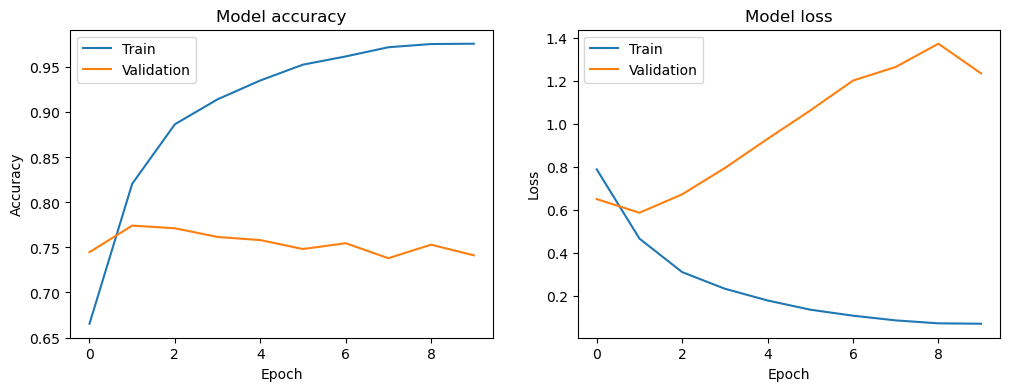

In [26]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(source['text'])
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=100)
X_test_pad = pad_sequences(X_test_seq, maxlen=100)

model = Sequential()
model.add(Embedding(5000, 128, input_length=100))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax')) 
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train_pad, y_train, epochs=10, batch_size=64, validation_data=(X_test_pad, y_test))

loss, accuracy = model.evaluate(X_test_pad, y_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

y_pred = model.predict(X_test_pad)
y_pred_classes = y_pred.argmax(axis=1)

print(classification_report(y_test, y_pred_classes))

# Print confusion matrix
print(confusion_matrix(y_test, y_pred_classes))

# Plotting training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plotting training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [27]:
new_texts = summaries_df['Summary'].tolist()

new_texts_seq = tokenizer.texts_to_sequences(new_texts)
new_texts_pad = pad_sequences(new_texts_seq, maxlen=100)

# Make predictions
predictions = model.predict(new_texts_pad)
predicted_classes = predictions.argmax(axis=1)

summaries_df['Predicted_Label'] = predicted_classes

print(summaries_df)

22/22 [==============================] - 1s 44ms/step
                                               Summary  Predicted_Label
0    world best performing tech stock bled average ...                2
1    leading cryptocurrencies edged lower tuesday b...                2
2    advanced micro device inc amd witnessed signif...                1
3    deepwater asset management managing partner ge...                1
4                        high time pounce nvidia stock                2
..                                                 ...              ...
678  apple face scrutiny european union potentially...                2
679  logitech logi expands music related device por...                1
680  sirius siri expands content andy richter call ...                2
681  amazon com inc amzn stock hit dazzling new mil...                2
682  taiwan semiconductor manufacturing tsm receive...                2

[683 rows x 2 columns]


In [28]:
sentiments = {0: "Bearish", 1: "Bullish", 2: "Neutral"}
summaries_df['Sentiment'] = summaries_df['Predicted_Label'].map(sentiments)
bearish_count = sum(summaries_df['Predicted_Label'] == 0)  # Bearish
bullish_count = sum(summaries_df['Predicted_Label'] == 1)  # Bullish
neutral_count = sum(summaries_df['Predicted_Label'] == 2)  # Neutral
feature_vector = [bearish_count, bullish_count, neutral_count]
print(f'Bearish Count: {bearish_count}')
print(f'Bullish Count: {bullish_count}')
print(f'Neutral Count: {neutral_count}')

Bearish Count: 71
Bullish Count: 195
Neutral Count: 417


In [29]:
def make_decision(bullish, bearish, neutral):
    total = bullish + bearish + neutral
    if bullish > 0.6 * total:
        return 'Buy'
    elif bearish > 0.6 * total:
        return 'Sell'
    else:
        return 'Hold'

In [30]:
decision = make_decision(bullish_count, bearish_count, neutral_count)
print(f'Decision for {ticker}: {decision}')

Decision for AAPL: Hold
